# 🚀 Barrier Reef YOLOv5 [Training]

### Hi kagglers, This is `Training` notebook using `YOLOv5`.


### Other notebooks in the competition
- [Barrier Reef YOLOv5 [Inference]](https://www.kaggle.com/ammarnassanalhajali/barrier-reef-yolov5-inference/edit)



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# 📚 YOLOv5
YOLO, "You Only Look Once", has a long and succesful history with real time object detection.

#  ⬇️ Download YOLOv5
Clone this repo and install requirements.txt dependencies, including Python>=3.8 and PyTorch>=1.7.

In [1]:
# # Download YOLOv5
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5

# # Install dependencies
# %pip install -qr requirements.txt  

# change directory
%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

/mnt/hdd1/wearly/kaggle/greatbarrierreef
Setup complete. Using torch 1.10.0 (NVIDIA GeForce RTX 3090)


In [2]:
# !add-apt-repository ppa:ubuntu-toolchain-r/test -y
# !apt-get update
# !apt-get upgrade libstdc++6 -y

# 🔨 Weights & Biases
* Weights & Biases is a set of tools that tracks machine learning experiments, visualizes metrics, and shares results.
* Weights & Biases is directly integrated into YOLOv5, providing experiment metric tracking, model and dataset versioning, rich model prediction visualization, and more.

In [3]:
# # Install W&B 
# !pip install -q --upgrade wandb

# # Login 
# import wandb

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient() 

# personal_key_for_api = user_secrets.get_secret("ke")
# ! wandb login $personal_key_for_api

# ☀️ Importing Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

from itertools import groupby
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
import glob
from os import listdir
from os.path import isfile, join
from glob import glob
import yaml

import shutil
from shutil import copyfile
import sys

from joblib import Parallel, delayed

# --- Read data ---
TRAIN_PATH = '/mnt/hdd1/wearly/kaggle/greatbarrierreef/data'

# 🔨 Functions

In [5]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes
def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row
def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes
def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [0, 0, 255], thickness=tf, lineType=cv2.LINE_AA)



def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

np.random.seed(8)
colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
colors=(255,0,0)

# 🍘 Hyperparameters

In [6]:
BATCH_SIZE = 8#16
EPOCHS = 30
IMG_SIZE=1280
Selected_Fold=4  #0..4

# 🍮 Loading Data

In [7]:
# Read in the data CSV files
df = pd.read_csv("/mnt/hdd1/wearly/kaggle/greatbarrierreef/data/train.csv")
df.head(5)

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []


# BBoxes
##### 📌 Note 
> We can see there are many images without any BBox. 

In [8]:
df["NumBBox"]=df['annotations'].apply(lambda x: str.count(x, 'x'))
df.head(5)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   NumBBox  
0        0  
1        0  
2        0  
3        0  
4        0

In [9]:
print(df["NumBBox"].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 15 18]


In [10]:
df_train=df[df["NumBBox"]>0]
df_train.sample(2)

video_id  sequence  video_frame  sequence_frame image_id  \
12642         1     60754         9077             661   1-9077   
12784         1     60754         9219             803   1-9219   

                                             annotations  NumBBox  
12642  [{'x': 506, 'y': 568, 'width': 28, 'height': 3...        7  
12784  [{'x': 336, 'y': 582, 'width': 65, 'height': 5...        5

In [11]:
print(df_train['NumBBox'].sum())

11898


> We have just 4919 images with 11898 BBox, we will use them in training.

In [12]:
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)
df_train.sample(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

  0%|          | 0/4919 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id  \
11059         1      8503         5907            2079   1-5907   
4769          0     53708         8946              61   0-8946   

                                             annotations  NumBBox  \
11059  [{'x': 4, 'y': 3, 'width': 65, 'height': 63}, ...        3   
4769   [{'x': 975, 'y': 411, 'width': 36, 'height': 3...        2   

                                                  bboxes  
11059  [[4, 3, 65, 63], [19, 406, 40, 59], [0, 466, 3...  
4769           [[975, 411, 36, 32], [1032, 471, 34, 30]]

# Size of Images
##### 📌 Note 
> All images have Width=1280 & Height=720 

In [13]:
df_train["Width"]=1280
df_train["Height"]=720
df_train.sample(2)

video_id  sequence  video_frame  sequence_frame image_id  \
5530         0     53708         9707             822   0-9707   
251          0     40258          251             251    0-251   

                                            annotations  NumBBox  \
5530  [{'x': 496, 'y': 210, 'width': 41, 'height': 34}]        1   
251   [{'x': 897, 'y': 286, 'width': 37, 'height': 35}]        1   

                    bboxes  Width  Height  
5530  [[496, 210, 41, 34]]   1280     720  
251   [[897, 286, 37, 35]]   1280     720

# Path of Images

In [14]:
df_train = df_train.progress_apply(get_path, axis=1)
df_train.sample(2)

  0%|          | 0/4919 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id  \
9347         1      8503         4195             367   1-4195   
158          0     40258          158             158    0-158   

                                            annotations  NumBBox  \
9347  [{'x': 346, 'y': 310, 'width': 40, 'height': 3...       11   
158   [{'x': 618, 'y': 296, 'width': 52, 'height': 55}]        1   

                                                 bboxes  Width  Height  \
9347  [[346, 310, 40, 30], [76, 346, 68, 54], [561, ...   1280     720   
158                                [[618, 296, 52, 55]]   1280     720   

                                             image_path  
9347  /mnt/hdd1/wearly/kaggle/greatbarrierreef/data/...  
158   /mnt/hdd1/wearly/kaggle/greatbarrierreef/data/...

# 🌈 Visualizing BBoxes

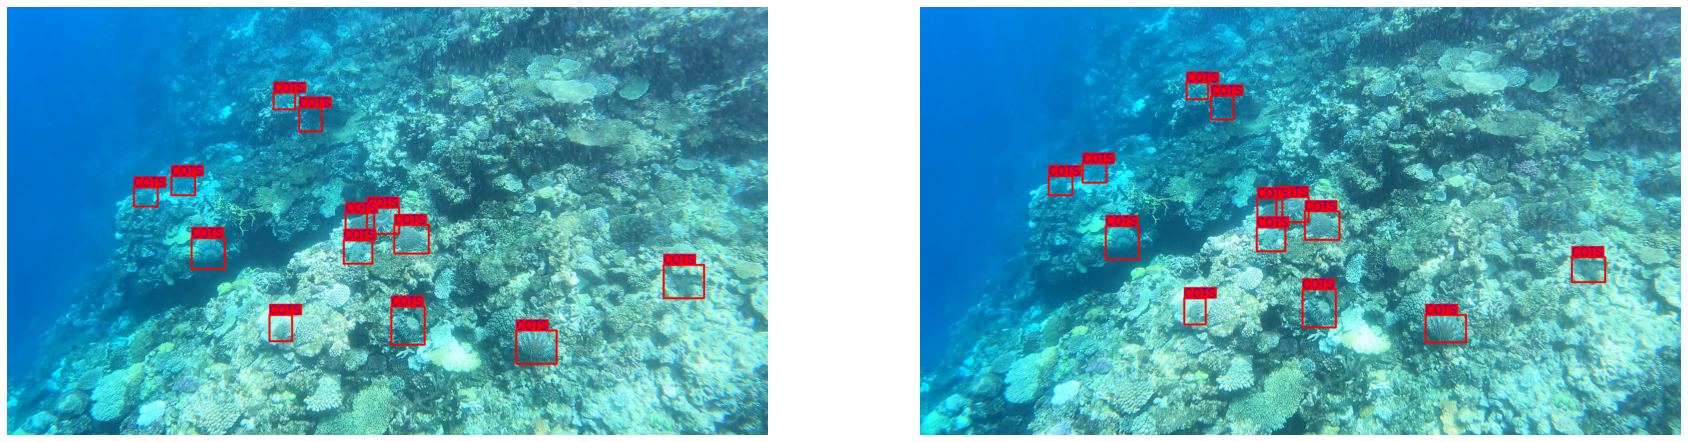

In [15]:
df_v = df_train[(df_train.NumBBox==13)].sample(2) 
fig,ax = plt.subplots(1,2,figsize=(30,20))
i=0;
for index, row in df_v.iterrows():
    img           = load_image(row.image_path)
    image_height  = row.Height
    image_width   = row.Width
    bboxes_coco   = np.array(row.bboxes)
    bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
    names         = ['COTS']*len(bboxes_coco)
    labels        = [0]*len(bboxes_coco)
    im=draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2)
    ax[i].imshow(im)
    ax[i].axis('OFF')
    i=i+1

# 🍚 Splitting Dataset

In [16]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 5) 
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())

0    1100
3     970
2     968
4     945
1     936
Name: fold, dtype: int64

## 🍚 Organize Directories

I organized train and val images and labels according to the example below.

```
/Kaggle/working
    /COTS
         /images
             /train/img0.jpg
             /val
         /labels
             /train/img0.txt
             /val
    /yolov5
```

In [17]:
os.makedirs('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/train', exist_ok=True)
os.makedirs('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/valid', exist_ok=True)
os.makedirs('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/train', exist_ok=True)
os.makedirs('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/valid', exist_ok=True)

In [18]:
for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    if row.fold != Selected_Fold:
        copyfile(f'{row.image_path}', f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/train/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/valid/{row.image_id}.jpg') 

  0%|          | 0/4919 [00:00<?, ?it/s]

In [20]:
list1 = os.listdir('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/train') # dir is your directory path
number_files1 = len(list1)
print("Number of images in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/train folder",number_files1)
list2 = os.listdir('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/valid') # dir is your directory path
number_files2 = len(list2)
print("Number of images in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/valid folder",number_files2)

Number of images in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/train folder 3974
Number of images in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/valid folder 945


# 🍜 Create `Data.YAML` file

The `data.yaml`, is the dataset configuration file that defines:

1. the dataset root directory and relative paths to train/val/test image directories (or paths to *.txt files with image paths).
1. the number of classes.
1. a list of class names.

> 📍 Note: The `data.yaml` is created in the `yolov5/data` directory as required. 

In [29]:
import yaml
with open('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/train.txt', 'w') as f:
    for path in glob('./train/*'):
        f.write(path+'\n')
            
with open('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/val.txt', 'w') as f:
    for path in glob('./val/*'):
        f.write(path+'\n')

data = dict(
    train = '/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/train',
    val = '/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/images/valid',
    
    nc    = 1, # number of classes
    names =  ['cots'] # classes
    )

with open('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [30]:
%cat ./yolov5/data/data.yaml

cat: ./yolov5/data/data.yaml: No such file or directory


In [31]:
!ls './yolov5/data'

ls: cannot access './yolov5/data': No such file or directory


## 🍮 Create Labels for YOLOv5

To label your images,a `.txt` file with the same name of the image,will be created (if no objects in image, no *.txt file is required)
The *.txt file specifications are:

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

> 📍 Note: We don't have to remove the images without bounding boxes from the training or validation sets. 

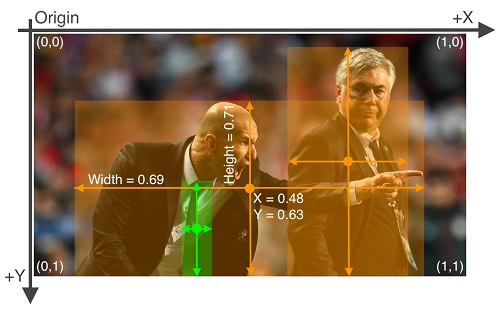

The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):

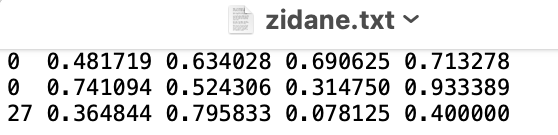

In [32]:
all_bboxes = []
for row_idx in tqdm(range(df_train.shape[0])):
    row = df_train.iloc[row_idx]
    # Get image
    image_name = row.image_id
    image_height = row.Height
    image_width  = row.Width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = [0]*num_bbox
    if row.fold != Selected_Fold:
        file_name = f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/train/{image_name}.txt'
    else:
        file_name = f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/valid/{image_name}.txt'

    with open(file_name, 'w') as f:
        bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            bb=str(bboxes_yolo[bbox_idx])
            bb=bb[1:-1]
            #annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
            annot = str(str(labels[bbox_idx])) + ' ' + bb + '\n'
            annot = ''.join(annot)
            annot = annot.strip('')
            f.write(annot)

  0%|          | 0/4919 [00:00<?, ?it/s]

In [33]:
list1 = os.listdir('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/train') # dir is your directory path
number_files1 = len(list1)
print("Number of txt file in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/train folder",number_files1)
list2 = os.listdir('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/valid') # dir is your directory path
number_files2 = len(list2)
print("Number of txt file in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/valid folder",number_files2)


Number of txt file in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/train folder 3974
Number of txt file in /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/valid folder 945


In [34]:
%cat '/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/COTS/labels/train/{list1[10]}'

0 0.37460937 0.97291667 0.06484375 0.05416667
0 0.3859375  0.81875    0.046875   0.08472222
0 0.29140625 0.62777778 0.0390625  0.075     


# 📦 Select a Model
Select a pretrained model to start training from. 
* Here we select YOLOv5s, the smallest and fastest model available.
* I will try YOLO5s

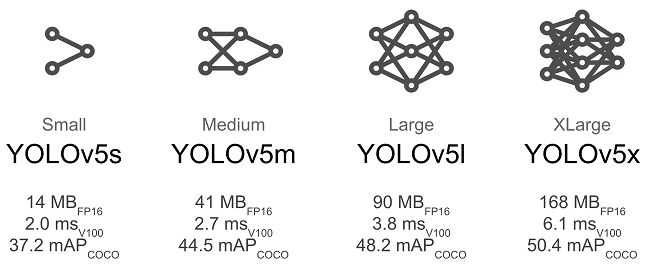

# 🚅 Train with W&B

In [36]:
%cd /mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/

/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5


All training results are saved to runs/train/ with incrementing run directories, i.e. runs/train/exp2, runs/train/exp3 etc. 

In [37]:
#best_weights = '/kaggle/input/nfl-weights/yolov5/kaggle-reef/exp/weights/best.pt' --weights {best_weights} \
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5x.pt \
                 --project kaggle-Reef 

train: weights=yolov5x.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=8, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=kaggle-Reef, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24265MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, sca

# Removing Files

In [39]:
%cd "../"
path = "COTS"
shutil.rmtree(path)

/mnt/hdd1/wearly/kaggle/greatbarrierreef/train


### Class Distribution

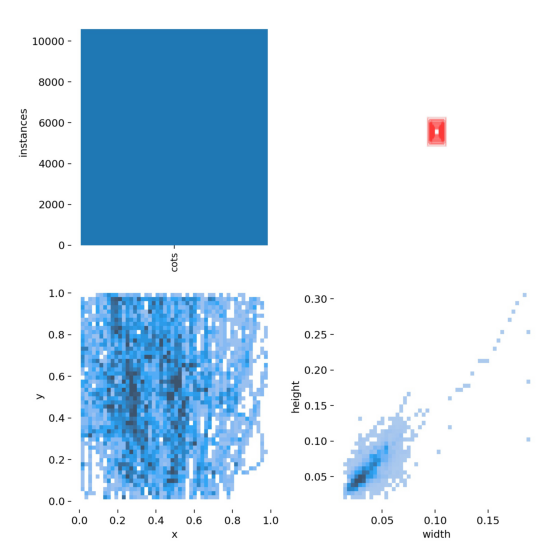

In [40]:
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/labels.jpg'));


### Batch Image

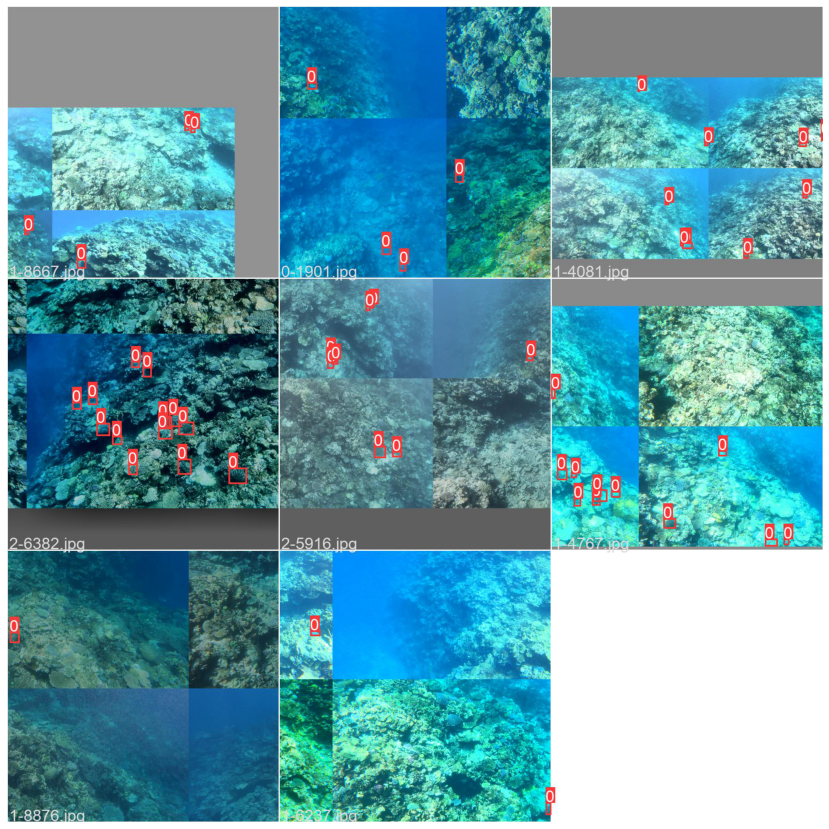

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/train_batch0.jpg'))


## P Curve

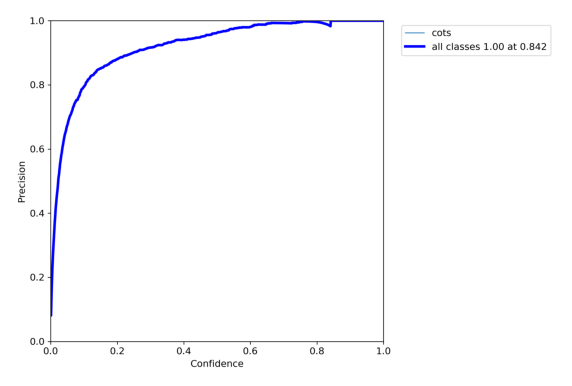

In [44]:
#!ls /kaggle/working/yolov5/kaggle-NFL/exp
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/P_curve.png'));

## PR Curve

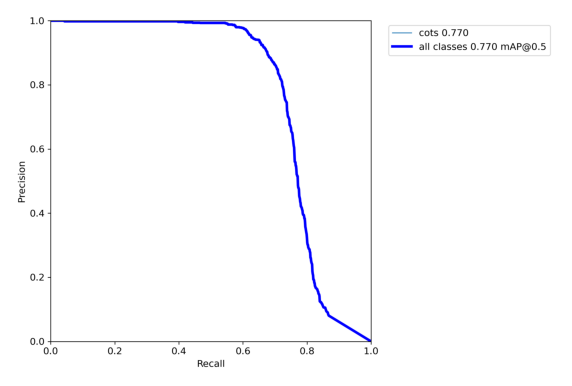

In [46]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/PR_curve.png'));

## F1 Curve

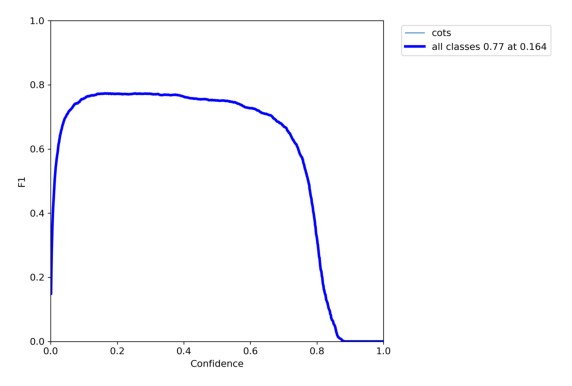

In [47]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/F1_curve.png'));

## R Curve

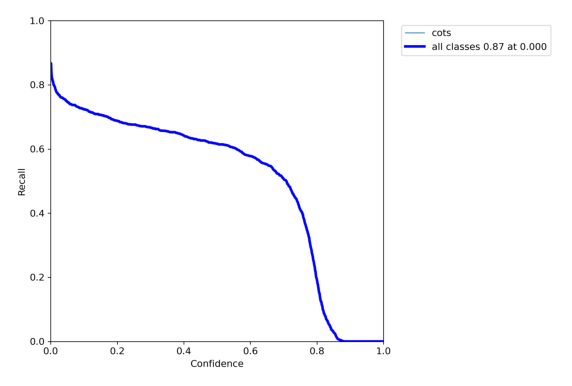

In [48]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/R_curve.png'));

### GT Vs Pred

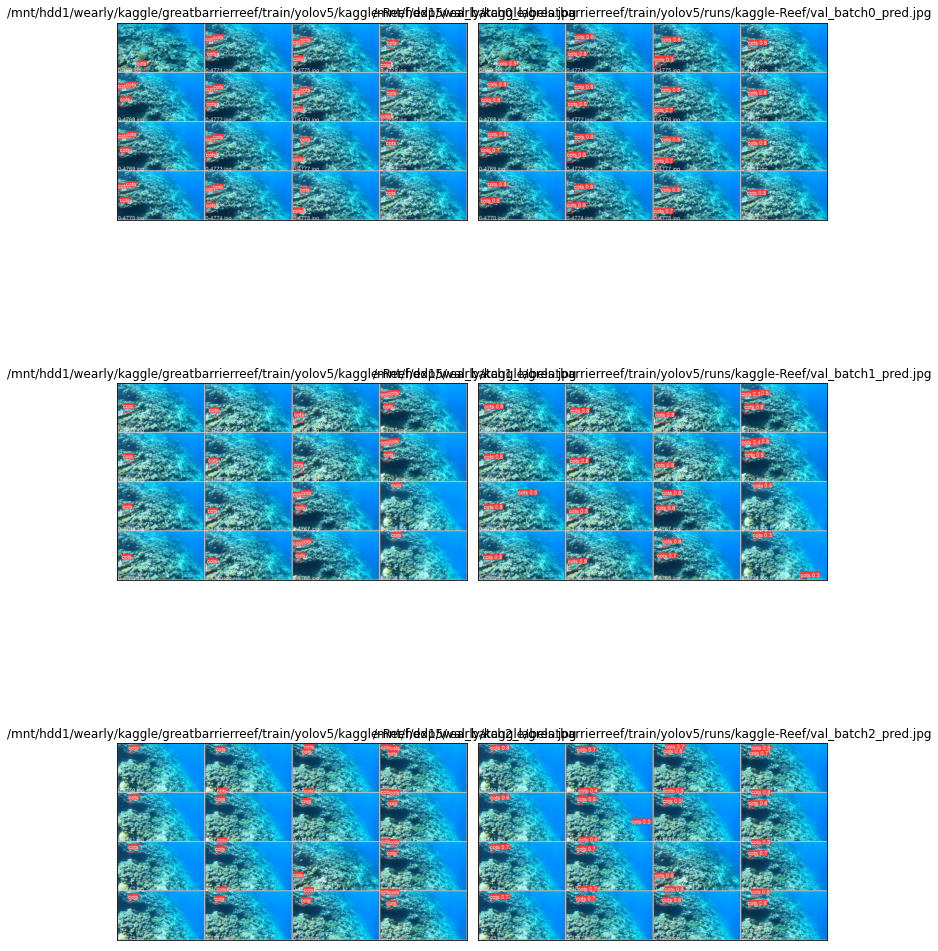

In [49]:
ig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/runs/kaggle-Reef/val_batch{row}_pred.jpg', fontsize = 12)

### (Loss, Map) Vs Epoch


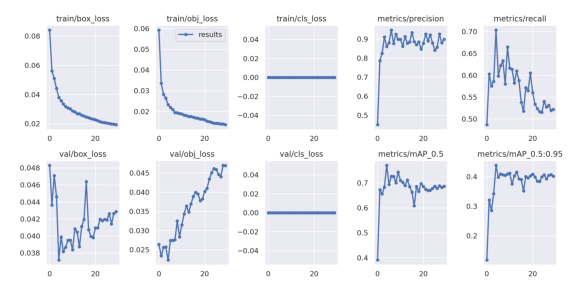

In [50]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/results.png'));

### Confusion Matrix

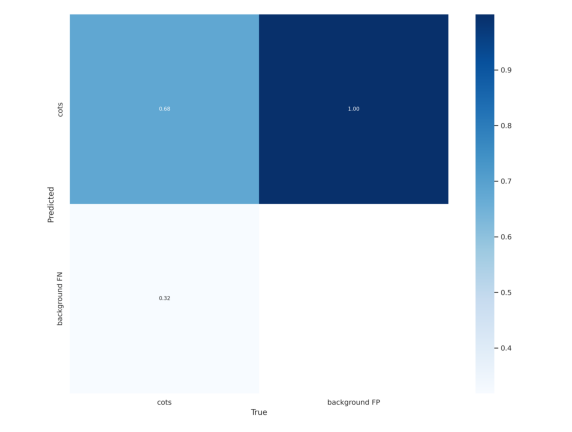

In [52]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/mnt/hdd1/wearly/kaggle/greatbarrierreef/train/yolov5/kaggle-Reef/exp5/confusion_matrix.png'));

# References

1. https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train
